# Guided-Backpropagation
<center>
<img src="https://jsideas.net/assets/materials/20180112/guided_backpropagation.png" width="600">
</center>

**Limiatation of Deconvnet**

Deconvnet does not work well without max-pooling layers.

By using the switches from a forward pass the ’deconvnet’ (and thereby its reconstruction) is hence conditioned
on an image and does not directly visualize learned features.

**High layer, Low layer**

This is in agreement with the fact that lower layers learn general features
with limited amount of invariance, which allows to reconstruct a single pattern that activates them.
However, higher layers learn more invariant representations, and there is no single image maximally
activating those neurons. Hence to get reasonable reconstructions it is necessary to condition on an
input image.
Hence to get reasonable reconstructions it is necessary to condition on an
input image.

<img src='http://research.sualab.com/assets/images/interpretable-machine-learning-overview-2/weight-visualization-example.png'>


**Modification of Deconvenet**

The ’deconvolution’ is
equivalent to a backward pass through the network, except that when propagating through a nonlinearity, its gradient is solely computed based on the top gradient signal, ignoring the bottom input.

# Import module


In [0]:
# import module
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn.functional as F
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline  
import random

# Hyperparameters



In [0]:
batch_size = 16
learning_rate = 0.0001
num_epoch = 10

# Data load: MNIST


In [0]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(226),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.MNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(226),
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

  0%|          | 16384/9912422 [00:00<01:25, 116255.76it/s]

9920512it [00:00, 24066715.96it/s]                           


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


32768it [00:00, 324192.06it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 5323462.98it/s]                           
8192it [00:00, 130152.00it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


# Model


In [0]:
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models

**Why static method?**

https://discuss.pytorch.org/t/custom-autograd-function-must-it-be-static/14980

In [0]:
class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None
        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        # replace ReLU with GuidedBackpropReLU
        for idx, module in self.model.features._modules.items():
            if module.__class__.__name__ == 'ReLU':
                self.model.features._modules[idx] = GuidedBackpropReLU.apply

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)
        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

In [0]:
def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

In [0]:
gb_model = GuidedBackpropReLUModel(model=models.vgg19(pretrained=True), use_cuda=True)

In [0]:
for images, labels in train_loader:
    image, label = images[0], labels[0]
    break
input_image = image
image = torch.cat([image, image, image], dim=0)
image = torch.unsqueeze(image, dim=0)

In [0]:
target_index = None
gb = gb_model(image.requires_grad_(True), index=None)

In [0]:
gb = gb.transpose((1, 2, 0))
gb = deprocess_image(gb)

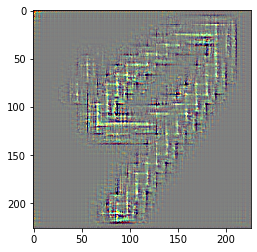

In [0]:
plt.imshow(gb)
plt.show()